https://www.kdnuggets.com/2017/03/simple-xgboost-tutorial-iris-dataset.html

In [1]:
import numpy as np
import pandas as pd

import xgboost as xgb

from sklearn.datasets import load_iris
from sklearn.cross_validation import train_test_split

C:\Users\Nivedit\AppData\Roaming\Python\Python36\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from IPython import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
np.random.seed(123)

In [4]:
iris = load_iris()

In [5]:
print(iris.DESCR)

Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
  

In [6]:
data = pd.DataFrame(iris.data)

In [7]:
data.columns = iris.feature_names

In [8]:
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [9]:
data['label'] = iris.target

In [10]:
data.sample(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
72,6.3,2.5,4.9,1.5,1
112,6.8,3.0,5.5,2.1,2
132,6.4,2.8,5.6,2.2,2
88,5.6,3.0,4.1,1.3,1
37,4.9,3.1,1.5,0.1,0


# Preparing Data

In [11]:
X = data.iloc[:,:-1].values
Y = data.iloc[:,-1].values

In [12]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=123)

In [13]:
for i in [trainX, trainY, testX, testY, X, Y]:
    i.shape

(120, 4)

(120,)

(30, 4)

(30,)

(150, 4)

(150,)

## Creating DMatirx for XGBoost

In [14]:
dtrain = xgb.DMatrix(trainX, label=trainY)
dtest = xgb.DMatrix(testX, label=testY)

Using **svmlight format** for less memory consumption

To use this -> first dump the array into svmlight

In [15]:
from sklearn.datasets import dump_svmlight_file

In [16]:
dump_svmlight_file(trainX, trainY, 'dtrain.svm', zero_based=True)
dump_svmlight_file(testX, testY, 'dtest.svm', zero_based=True)

dtrain_svm = xgb.DMatrix('dtrain.svm')
dtest_svm = xgb.DMatrix('dtest.svm')

[08:26:22] 120x4 matrix with 480 entries loaded from dtrain.svm
[08:26:23] 30x4 matrix with 120 entries loaded from dtest.svm


### Setting XGB params

In [17]:
param = {
    'max_depth' : 3, # maximum depth of each tree
    'eta' : 0.3, # training step for each iteration
    'silent' : 1, # logging mode - quiet
    'objective' : 'multi:softprob', # error evaluation for multi class training
    'num_class' : 3 # number of classes that exist in this dataset
}

num_round = 20 # number of training iterations

#### Train

In [18]:
xgb_cls = xgb.train(param, dtrain, num_round)

In [19]:
# To see how the model looks you can also dump it in human readable form
xgb_cls.dump_model('dump_iris_xgb.txt')

In [22]:
pred_train = xgb_cls.predict(dtrain)
pred_test = xgb_cls.predict(dtest)

In [24]:
pred_train[:5]
pred_test[:5]

array([[0.0037679 , 0.00624413, 0.989988  ],
       [0.0140263 , 0.31718937, 0.6687843 ],
       [0.9904304 , 0.00605034, 0.00351922],
       [0.9904304 , 0.00605034, 0.00351922],
       [0.0070225 , 0.98412734, 0.00885019]], dtype=float32)

array([[0.00699146, 0.7988227 , 0.1941859 ],
       [0.00324378, 0.00537555, 0.99138063],
       [0.00376983, 0.00573472, 0.99049544],
       [0.003449  , 0.99305636, 0.00349463],
       [0.9904304 , 0.00605034, 0.00351922]], dtype=float32)

Getting Predictions for each of three classes in probability form

To get this representing a single number, will get the highest from each

In [25]:
pred_train_classes = np.array([np.argmax(line) for line in pred_train])  # Converting into ARRAY otherwise it is a LIST
pred_test_classes = np.array([np.argmax(line) for line in pred_test])

pred_train_classes[:5]
pred_test_classes[:5]

array([2, 2, 0, 0, 1], dtype=int64)

array([1, 2, 2, 1, 0], dtype=int64)

In [26]:
for i in [pred_train_classes, pred_train, pred_test_classes, pred_test]:
    i.shape

(120,)

(120, 3)

(30,)

(30, 3)

### Confusion Matrix & Accuracy

In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
# Function to Plot Confusion Matrix
def fun_plot_confusion_matrix(conf):
    plt.rcParams['figure.figsize'] = 4,3
    cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
    sns.heatmap(conf,cmap = cmap,xticklabels=['0','1','2'],yticklabels=['0','1','2'],annot=True, fmt="d",)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

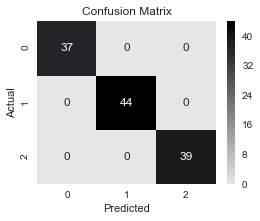

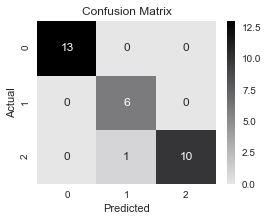

In [30]:
conf_train = confusion_matrix(trainY, pred_train_classes)
conf_test = confusion_matrix(testY, pred_test_classes)

fun_plot_confusion_matrix(conf_train)
fun_plot_confusion_matrix(conf_test)

Only 1 class has been identified incorrectly for test and seems that there is 100% accuracy for train

In [32]:
accuracy_score(trainY, pred_train_classes)
accuracy_score(testY, pred_test_classes)

1.0

0.9666666666666667